# Plotting and exploring RNA DE data
Purpose: Generate differential expression results and publication-ready visualisations

“Recent selection in heavily fished Malawi cichlids” (Hooft van Huysduynen et al., 2025).



In [47]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

import pandas as pd
# import scanpy as sc
# import gseapy as gp
# from gseapy.plot import gseaplot

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
import os
# import venn

#volcano
# from sanbomics.plots import volcano

In [48]:
def volcano(data, log2fc = 'log2FoldChange', pvalue = 'padj', symbol = 'symbol',
           baseMean = None, 
           pval_thresh = 0.05,
           log2fc_thresh = 0.75,
           to_label = 5, 
           color_dict = None, shape_dict = None,
           fontsize = 10,
           colors = ['tab:red', 'dimgrey', 'Blue'],
           top_right_frame = False,
           figsize = (5,5), legend_pos = (1.4,1),
           
           point_sizes = (15,150),
           save = False,
           shapes = None,
           shape_order = None):
    
    '''
    Make a volcano plot from a pandas dataframe of directly from a csv.
    
    data : pandas.DataFrame or path to csv
    log2fc : string
        column name of log2 Fold-Change values
    pvalue : string
        column name of the p values to be converted to -log10 P values
    symbol : string
        column name of gene IDs to use
    baseMean : string
        column name of base mean values for each gene. If this is passed, 
        the size of the points will vary.
    pval_thresh : numeric
        threshold pvalue for points to be significant. Also controls horizontal
        line.
    log2fc_thresh : numeric
        threshold for the absolute value of the log2 fold change to be considered
        significant. Also controls vertical lines
    to_label : int or list
        If an int is passed, that number of top down and up genes will be labeled.
        If a list of gene Ids is passed, only those will be labeled.
    color_dict : dictionary
        dictionary to color dots by. Up to 11 categories with default colors.
        Pass list of genes and the category to group them by. {category : ['gene1', gene2]}
        Default colors are: ['dimgrey', 'lightgrey', 'tab:blue', 'tab:orange',
        'tab:green', 'tab:red', 'tab:purple','tab:brown', 'tab:pink', 
        'tab:olive', 'tab:cyan']
    shape_dict : dictionary
        dictionary to shape dots by. Up to 6 categories. Pass list of genes as values
        and category as key. {category : ['gene1', gene2], category2 : ['gene3']}
    fontsize : int
        size of labels
    colors : list
        order and colors to use. Default ['dimgrey', 'lightgrey', 'black']
    top_right_frame : Boolean
        Show the top and right frame. True/False
    figsize : tuple
        Size of figure. (x, y)
    point_sizes : tuple
        lower and upper bounds of point sizes. If baseMean is not None.
        (lower, upper)
    save : boolean | string
        If true saves default file name. Pass string as path to output file. Will
        add a .svg/.png to string. Saves as both png and svg.
    shapes : list
        pass matplotlib marker ids to change default shapes/order
        Default shapes order is: ['o', '^', 's', 'X', '*', 'd']
    shape_order : list
        If you want to change the order of categories for your shapes. Pass
        a list of your categories.
    
    '''
    
    
    
    
    if isinstance(data, str):
        df = pd.read_csv(data)
    else: 
        df = data.copy(deep = True)
        
        
    #clean and imput 0s
    df = df.dropna()
    if df[pvalue].min() == 0:
        print('0s encountered for p value, imputing 1e-323')
        print('impute your own value if you want to avoid this')
        df[pvalue][df[pvalue] == 0] = 1e-323
        
        
    
    pval_thresh = -np.log10(pval_thresh) #convert p value threshold to nlog10
    df['nlog10'] = -np.log10(df[pvalue]) #make nlog10 column
    df['sorter'] = df['nlog10']*df[log2fc] #make a column to pick top genes
    
    
    #size the dots by basemean if a column id is passed
    if baseMean is not None:
        df['logBaseMean'] = np.log(df[baseMean])
        baseMean = 'logBaseMean'
    else:
        point_sizes = None
    
    
    #color dots by {label:[list of genes]}
    
    
    
    
    #make label list of top x genes up and down, or based on list input
    if isinstance(to_label, int):
        label_df = pd.concat(
        (df.sort_values('sorter')[-to_label:],
        df.sort_values('sorter')[0:to_label]))
        
    else:
        label_df = df[df[symbol].isin(to_label)]
        
        
        

    
    #color light grey if below thresh, color picked black
    def map_color_simple(a):
        log2FoldChange, zymbol, nlog10 = a
        if zymbol in label_df[symbol].tolist():
            return 'picked'
            
        if abs(log2FoldChange) < log2fc_thresh or nlog10 < pval_thresh:
            return 'not DE'
        return 'DE'
    
    if color_dict is None:
        df['color'] = df['color'] = df[[log2fc, symbol, 'nlog10']].apply(map_color_simple, axis = 1)
        hues = ['DE', 'not DE', 'picked'][:len(df.color.unique())] #order of colors
    
    #coloring if dictionary passed
    def map_color_complex(a):
        log2FoldChange, zymbol, nlog10 = a
        
        for k in list(color_dict):
            if zymbol in color_dict[k]:
                return k
        if abs(log2FoldChange) < log2fc_thresh or nlog10 < pval_thresh:
            return 'not DE'
        return 'DE'
    
    if color_dict is not None:
        df['color'] = df['color'] = df[[log2fc, symbol, 'nlog10']].apply(map_color_complex, axis = 1)
        user_added_cats = [x for x in df.color.unique() if x not in ['DE', 'not DE']]
        hues = ['DE', 'not DE'] + user_added_cats
        hues = hues[:len(df.color.unique())] #order of colors
        if colors == ['dimgrey', 'lightgrey', 'black']:
            colors = ['dimgrey', 'lightgrey', 'tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:purple',
                     'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']
            
            
    #map shapes if dictionary exists
    def map_shape(zymbol):
        for k in list(shape_dict):
            if zymbol in shape_dict[k]:
                return k

        return 'other'
            
    if shape_dict is not None:
        df['shape'] =  df[symbol].map(map_shape)
        user_added_cats = [x for x in df['shape'].unique() if x  != 'other']
        shape_order = ['other'] + user_added_cats
        if shapes is None:
            shapes = ['o', '^', 's', 'X', '*', 'd']
        shapes = shapes[:len(df['shape'].unique())]
        shape_col = 'shape'
    else:
        shape_col = None
    
    
    

    #build palette
    colors = colors[:len(df.color.unique())]

    
    
    plt.figure(figsize = figsize)
    ax = sns.scatterplot(data = df, x = log2fc, y = 'nlog10',                 
                hue = 'color', hue_order = hues, palette = colors,
                        size = baseMean, sizes = point_sizes, alpha=0.5,
                        style = shape_col, style_order = shape_order, markers = shapes)
    

    
    
    #make labels
    texts = []
    for i in range(len(label_df)):
        
        txt = plt.text(x = label_df.iloc[i][log2fc],
                              y = label_df.iloc[i].nlog10,
                              s = label_df.iloc[i][symbol],
                              fontsize = fontsize,
                              weight = 'normal')
        
        txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        texts.append(txt)
    adjust_text(texts, arrowprops = dict(arrowstyle = '-', color = 'k', zorder = 5))
    
    
    
    
    
    #plot vertical and horizontal lines
    ax.axhline(pval_thresh, zorder = 0, c = 'k', lw = 2, ls = '--')
    ax.axvline(log2fc_thresh, zorder = 0, c = 'k', lw = 2, ls = '--')
    ax.axvline(log2fc_thresh * -1, zorder = 0, c = 'k', lw = 2, ls = '--')
    
    
    
    #make things pretty
    for axis in ['bottom', 'left', 'top', 'right']:
        ax.spines[axis].set_linewidth(2)
        
    if not top_right_frame:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    ax.tick_params(width = 2)
    plt.xticks(size = 11, weight = 'bold')
    plt.yticks(size = 11, weight = 'bold')
    plt.xlabel("$log_{2}$ fold change", size = 15)
    plt.ylabel("-$log_{10}$ FDR", size = 15)
    
    plt.legend(loc = 1, bbox_to_anchor = legend_pos, frameon = False, prop = {'weight':'bold'})
    
    if save == True:
        files = os.listdir()
        for x in range(100):
            file_pref = "volcano_" + "%02d" % (x,)
            if len([x for x in files if x.startswith(file_pref)]) == 0:
                plt.savefig(file_pref + '.png', dpi = 300, bbox_inches = 'tight')
                plt.savefig(file_pref + '.svg', bbox_inches = 'tight')
                break
    elif isinstance(save, str):
        plt.savefig(save + '.png', dpi = 300, bbox_inches = 'tight')
        plt.savefig(save + '.svg', bbox_inches = 'tight')
                
    
    
    plt.show()

In [49]:
def volcano2(data, log2fc = 'log2FoldChange', pvalue = 'padj', symbol = 'symbol',
           baseMean = None, 
           pval_thresh = 0.05,
           log2fc_thresh = 0.75,
           to_label = 5, 
           color_dict = None, shape_dict = None,
           fontsize = 10,
           colors = ['tab:red','dimgrey', 'tab:blue', 'tab:orange'],
           top_right_frame = False,
           figsize = (5,5), legend_pos = (1.4,1),
           
           point_sizes = (15,150),
           save = False,
           shapes = None,
           shape_order = None):
    
    '''
    Make a volcano plot from a pandas dataframe of directly from a csv.
    
    data : pandas.DataFrame or path to csv
    log2fc : string
        column name of log2 Fold-Change values
    pvalue : string
        column name of the p values to be converted to -log10 P values
    symbol : string
        column name of gene IDs to use
    baseMean : string
        column name of base mean values for each gene. If this is passed, 
        the size of the points will vary.
    pval_thresh : numeric
        threshold pvalue for points to be significant. Also controls horizontal
        line.
    log2fc_thresh : numeric
        threshold for the absolute value of the log2 fold change to be considered
        significant. Also controls vertical lines
    to_label : int or list
        If an int is passed, that number of top down and up genes will be labeled.
        If a list of gene Ids is passed, only those will be labeled.
    color_dict : dictionary
        dictionary to color dots by. Up to 11 categories with default colors.
        Pass list of genes and the category to group them by. {category : ['gene1', gene2]}
        Default colors are: ['dimgrey', 'lightgrey', 'tab:blue', 'tab:orange',
        'tab:green', 'tab:red', 'tab:purple','tab:brown', 'tab:pink', 
        'tab:olive', 'tab:cyan']
    shape_dict : dictionary
        dictionary to shape dots by. Up to 6 categories. Pass list of genes as values
        and category as key. {category : ['gene1', gene2], category2 : ['gene3']}
    fontsize : int
        size of labels
    colors : list
        order and colors to use. Default ['dimgrey', 'lightgrey', 'black']
    top_right_frame : Boolean
        Show the top and right frame. True/False
    figsize : tuple
        Size of figure. (x, y)
    point_sizes : tuple
        lower and upper bounds of point sizes. If baseMean is not None.
        (lower, upper)
    save : boolean | string
        If true saves default file name. Pass string as path to output file. Will
        add a .svg/.png to string. Saves as both png and svg.
    shapes : list
        pass matplotlib marker ids to change default shapes/order
        Default shapes order is: ['o', '^', 's', 'X', '*', 'd']
    shape_order : list
        If you want to change the order of categories for your shapes. Pass
        a list of your categories.
    
    '''
    
    
    
    
    if isinstance(data, str):
        df = pd.read_csv(data)
    else: 
        df = data.copy(deep = True)
        
        
    #clean and imput 0s
    df = df.dropna()
    if df[pvalue].min() == 0:
        print('0s encountered for p value, imputing 1e-323')
        print('impute your own value if you want to avoid this')
        df[pvalue][df[pvalue] == 0] = 1e-323
        
        
    
    pval_thresh = -np.log10(pval_thresh) #convert p value threshold to nlog10
    df['nlog10'] = -np.log10(df[pvalue]) #make nlog10 column
    df['sorter'] = df['nlog10']*df[log2fc] #make a column to pick top genes
    
    
    #size the dots by basemean if a column id is passed
    if baseMean is not None:
        df['logBaseMean'] = np.log(df[baseMean])
        baseMean = 'logBaseMean'
    else:
        point_sizes = None
    
    
    #color dots by {label:[list of genes]}
    
    
    
    
    #make label list of top x genes up and down, or based on list input
    if isinstance(to_label, int):
        label_df = pd.concat(
        (df.sort_values('sorter')[-to_label:],
        df.sort_values('sorter')[0:to_label]))
        
    else:
        label_df = df[df[symbol].isin(to_label)]
        
        
        

    
    #color light grey if below thresh, color picked black
    # Update map_color_simple to include orange category
    def map_color_simple(a):
        log2FoldChange, zymbol, nlog10 = a
        if abs(log2FoldChange) < log2fc_thresh:  # New condition for orange points
            return 'orange'
        if abs(log2FoldChange) > log2fc_thresh and nlog10 > pval_thresh:  # Below log2 fold change but above log10 FDR
            return 'blue'
        if zymbol in label_df[symbol].tolist():  # Points explicitly selected for labeling
            return 'picked'
        if abs(log2FoldChange) < log2fc_thresh or nlog10 < pval_thresh:  # Below thresholds
            return 'not DE'
        return 'DE'  # Default for significant points


    # Update color_dict logic if None is passed
    if color_dict is None:
        df['color'] = df[[log2fc, symbol, 'nlog10']].apply(map_color_simple, axis=1)
        hues = ['DE', 'Log2 fold change', 'orange', 'blue', 'picked'][:len(df.color.unique())]

    #coloring if dictionary passed
    def map_color_complex(a):
        log2FoldChange, zymbol, nlog10 = a

    
        log2FoldChange, zymbol, nlog10 = a
        for k in list(color_dict):
            if zymbol in color_dict[k]:
                return k
        if abs(log2FoldChange) < log2fc_thresh:  # New condition for orange points
            return 'orange'
        if abs(log2FoldChange) < log2fc_thresh and nlog10 > pval_thresh:  # Below log2 fold change but above log10 FDR
            return 'blue'
        if zymbol in label_df[symbol].tolist():  # Points explicitly selected for labeling
            return 'picked'
        if abs(log2FoldChange) > log2fc_thresh and nlog10 > pval_thresh:  # Below thresholds
            return 'DE'
        return 'non DE'  # Default for significant points
    
    if color_dict is not None:
        df['color'] = df['color'] = df[[log2fc, symbol, 'nlog10']].apply(map_color_complex, axis = 1)
        user_added_cats = [x for x in df.color.unique() if x not in ['DE', 'not DE']]
        hues = ['DE', 'not DE'] + user_added_cats
        hues = hues[:len(df.color.unique())] #order of colors
        if colors == ['dimgrey', 'lightgrey', 'black']:
            colors = ['dimgrey', 'lightgrey', 'black', 'tab:red', 'lightgrey', 'tab:orange', 'tab:red', 'tab:orange', 'tab:green', 'tab:blue']

            
            
    #map shapes if dictionary exists
    def map_shape(zymbol):
        for k in list(shape_dict):
            if zymbol in shape_dict[k]:
                return k

        return 'other'
            
    if shape_dict is not None:
        df['shape'] =  df[symbol].map(map_shape)
        user_added_cats = [x for x in df['shape'].unique() if x  != 'other']
        shape_order = ['other'] + user_added_cats
        if shapes is None:
            shapes = ['o', '^', 's', 'X', '*', 'd']
        shapes = shapes[:len(df['shape'].unique())]
        shape_col = 'shape'
    else:
        shape_col = None
    
    
    

    #build palette
    colors = colors[:len(df.color.unique())]

    
    
    plt.figure(figsize = figsize)
    ax = sns.scatterplot(data = df, x = log2fc, y = 'nlog10',                 
                hue = 'color', hue_order = hues, palette = colors,
                        size = baseMean, sizes = point_sizes, alpha=0.5,
                        style = shape_col, style_order = shape_order, markers = shapes)
    

    
    
    #make labels
    texts = []
    for i in range(len(label_df)):
        
        txt = plt.text(x = label_df.iloc[i][log2fc],
                              y = label_df.iloc[i].nlog10,
                              s = label_df.iloc[i][symbol],
                              fontsize = fontsize,
                              weight = 'normal')
        
        txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        texts.append(txt)
    adjust_text(texts, arrowprops = dict(arrowstyle = '-', color = 'k', zorder = 5))
    
    
    
    
    
    #plot vertical and horizontal lines
    ax.axhline(pval_thresh, zorder = 0, c = 'k', lw = 2, ls = '--')
    ax.axvline(log2fc_thresh, zorder = 0, c = 'k', lw = 2, ls = '--')
    ax.axvline(log2fc_thresh * -1, zorder = 0, c = 'k', lw = 2, ls = '--')
    
    
    
    #make things pretty
    for axis in ['bottom', 'left', 'top', 'right']:
        ax.spines[axis].set_linewidth(2)
        
    if not top_right_frame:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    ax.tick_params(width = 2)
    plt.xticks(size = 11, weight = 'bold')
    plt.yticks(size = 11, weight = 'bold')
    plt.xlabel("$log_{2}$ fold change", size = 15)
    plt.ylabel("-$log_{10}$ FDR", size = 15)
    
    plt.legend(loc = 1, bbox_to_anchor = legend_pos, frameon = False, prop = {'weight':'bold'})
    
    if save == True:
        files = os.listdir()
        for x in range(100):
            file_pref = "volcano_" + "%02d" % (x,)
            if len([x for x in files if x.startswith(file_pref)]) == 0:
                plt.savefig(file_pref + '.png', dpi = 300, bbox_inches = 'tight')
                plt.savefig(file_pref + '.svg', bbox_inches = 'tight')
                break
    elif isinstance(save, str):
        plt.savefig(save + '.png', dpi = 300, bbox_inches = 'tight')
        plt.savefig(save + '.svg', bbox_inches = 'tight')
                
    
    
    plt.show()

In [50]:
def volcano2(data, log2fc='log2FoldChange', pvalue='padj', symbol='symbol',
           baseMean=None, 
           pval_thresh=0.05,
           log2fc_thresh=0.75,
           to_label=5, 
           color_dict=None, shape_dict=None,
           fontsize=15,
           colors=['tab:blue', 'dimgrey', 'tab:orange', 'tab:red'],
           top_right_frame=False,
           figsize=(5, 5), legend_pos=(1.2, 1),
           point_sizes=(15, 150),
           save=False,
           shapes=None,
           shape_order=None):
    """
    Generate a volcano plot from a pandas DataFrame or a CSV file.
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from adjustText import adjust_text
    import matplotlib.patheffects as PathEffects

    # Load data
    if isinstance(data, str):
        df = pd.read_csv(data)
    else:
        df = data.copy(deep=True)

    # Clean and preprocess data
    df = df.dropna(subset=[log2fc, pvalue])
    if (df[pvalue] == 0).any():
        df[pvalue] = df[pvalue].replace(0, 1e-323)

    pval_thresh_nlog10 = -np.log10(pval_thresh)  # Convert p-value threshold to -log10 scale
    df['nlog10'] = -np.log10(df[pvalue])  # Create -log10 p-value column
    df['sorter'] = df['nlog10'] * df[log2fc]  # Sorting metric for labeling

    if baseMean is not None:
        df['logBaseMean'] = np.log(df[baseMean])
        baseMean = 'logBaseMean'
    else:
        point_sizes = None

    # Labeling logic
    if isinstance(to_label, int):
        label_df = pd.concat([
            df.sort_values('sorter').head(to_label),
            df.sort_values('sorter').tail(to_label)
        ])
    else:
        label_df = df[df[symbol].isin(to_label)]

    # Define color mapping
    def map_color(a):
        log2FoldChange, zymbol, nlog10 = a
        if abs(log2FoldChange) >= log2fc_thresh and nlog10 >= pval_thresh_nlog10:
            return 'log$_{10}$ FDR & log$_{2}$ FC'  # Significant DE
        if abs(log2FoldChange) < log2fc_thresh and nlog10 >= pval_thresh_nlog10:
            return 'log$_{10}$ FDR'  # High FDR but not large fold-change
        if abs(log2FoldChange) >= log2fc_thresh and nlog10 < pval_thresh_nlog10:
            return 'log$_{2}$ FC'  # Large fold-change but not significant FDR
        return 'Not DE'  # Not DE

    df['color'] = df[[log2fc, symbol, 'nlog10']].apply(map_color, axis=1)

    # Apply shapes if specified
    def map_shape(zymbol):
        for category, genes in (shape_dict or {}).items():
            if zymbol in genes:
                return category
        return 'other'

    if shape_dict:
        df['shape'] = df[symbol].apply(map_shape)
        user_shapes = [x for x in df['shape'].unique() if x != 'other']
        shape_order = ['other'] + user_shapes
        shapes = shapes or ['o', '^', 's', 'X', '*', 'd'][:len(df['shape'].unique())]
        shape_col = 'shape'
    else:
        shape_col = None

    # Build the plot
    plt.figure(figsize=figsize)
    sns.scatterplot(
        data=df, x=log2fc, y='nlog10', hue='color', palette=colors,
        size=baseMean, sizes=point_sizes, style=shape_col, style_order=shape_order, alpha=0.5
    )

    # Add labels
    texts = []
    for _, row in label_df.iterrows():
        txt = plt.text(
            x=row[log2fc], y=row['nlog10'], s=row[symbol],
            fontsize=fontsize, weight='normal',
            path_effects=[PathEffects.withStroke(linewidth=3, foreground='w')]
        )
        texts.append(txt)
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='k', zorder=5))

    # Add significance lines
    plt.axhline(pval_thresh_nlog10, linestyle='--', color='k', linewidth=2)
    plt.axvline(log2fc_thresh, linestyle='--', color='k', linewidth=2)
    plt.axvline(-log2fc_thresh, linestyle='--', color='k', linewidth=2)

    # Customize appearance
    plt.gca().spines['top'].set_visible(top_right_frame)
    plt.gca().spines['right'].set_visible(top_right_frame)
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['left'].set_linewidth(2)
    plt.tick_params(width=2)
    plt.xlabel("$log_{2}$ Fold Change", fontsize=25)
    plt.ylabel("-$log_{10}$ FDR", fontsize=25)
    plt.xticks(size=15, weight='bold')
    plt.yticks(size=15, weight='bold')
    plt.legend(loc=1, bbox_to_anchor=legend_pos, frameon=False, prop={'size': 15})

    # Save if required
    if save:
        file_prefix = save if isinstance(save, str) else "volcano_plot"
        plt.savefig(f"{file_prefix}.png", dpi=300, bbox_inches='tight')
        plt.savefig(f"{file_prefix}.svg", bbox_inches='tight')

    plt.show()


In [51]:
def ncbi_to_loc(loc):
    try:
        return 'LOC'+ str(int(loc))
    except ValueError:
        return np.nan

### some important paths

In [52]:
ana_dir = "/scratch/antwerpen/grp/asvardal/projects/cichlid/analyses/Copadichromis_FIE_Alex"
out_dir = f"{ana_dir}/Figures/DE_alex"
rasflow_fp = f"{ana_dir}/analyses/RASflow"

In [53]:
# all C. mloto file paths

CM_brain_count_fp = f"{rasflow_fp}/output/mloto_ensemble_newannotation_Brain_DEA_analysis/genome/countFile"
CM_gonads_count_fp = f"{rasflow_fp}/output/mloto_ensemble_newannotation_Gonads_DEA_analysis/genome/countFile"
CM_gills_count_fp = f"{rasflow_fp}/output/mloto_ensemble_newannotation_Gills_DEA_analysis/genome/countFile"
CM_muscle_count_fp = f"{rasflow_fp}/output/mloto_ensemble_newannotation_Muscle_DEA_analysis/genome/countFile"
CM_liver_count_fp = f"{rasflow_fp}/output/mloto_ensemble_newannotation_Liver_DEA_analysis/genome/countFile"

In [54]:
#metadata for the ncbi_ids
reference_table_fn = "/scratch/antwerpen/grp/asvardal/projects/cichlid/reference/fAstCal1.2/annotation/biomart_zfin-ncbi_ids.txt"

In [55]:
#metadata
md_fn = "/scratch/antwerpen/grp/asvardal/projects/cichlid/reads/RNAseq/Copadichromis-rnaseq/Copadichromis-rnaseq_25_01_22.txt"

In [56]:
rna_metadata = pd.read_table(md_fn, sep = '\t', header=0)
rna_metadata = rna_metadata.set_index('seq_id')
##exclude any errors, marked in error column of metadata file
rna_metadata = rna_metadata[rna_metadata['exclude'].isnull()]

In [57]:
rna_metadata = rna_metadata[rna_metadata['species'] == 'Copadichromis virginalis']

In [58]:
###extract populations
sample_mt_fn = "/scratch/antwerpen/grp/asvardal/projects/cichlid/metadata/VirginalisMloto_FIE_mt_2023-06-09.tsv"

sample_mt = pd.read_csv(sample_mt_fn, dtype=str, sep='\t', index_col=0)#.set_index("sequence_id", drop=False)
sample_mt.drop(sample_mt[sample_mt["exclude"].notnull()].index.values, inplace = True)

In [59]:
# extract all supplier IDs from metadata["sample"]
rna_metadata["supplier_id"] = rna_metadata["sample"].str.split(" ").str[0]

# use those to filter df by its supplier_id column
# matches = sample_mt.loc[sample_mt["supplier_id"].isin(supplier_ids), "location_pub"]
lookup = sample_mt.set_index("supplier_id")["location_pub"].to_dict()

rna_metadata["populations"] = rna_metadata["supplier_id"].map(lookup)

## Analysis 

### read in all tissue counts

In [138]:
tissues = ['Gonads', 'Brain','Gills','Muscle','Liver']
df_list = []

for tissue in tissues:
        print(tissue)
        samples = list(rna_metadata[rna_metadata['tissue']==tissue].index)
        CM_count_fp = (f'{CM_gonads_count_fp}' if tissue == 'Gonads'
                else f'{CM_brain_count_fp}' if tissue == 'Brain'
                else f'{CM_gills_count_fp}' if tissue == 'Gills'
                else f'{CM_muscle_count_fp}' if tissue == 'Muscle'
                else f'{CM_liver_count_fp}' if tissue == 'Liver'
                else None)
        
        for i in samples:
            fn_CM = f"{CM_count_fp}/{i}_count.tsv"

            # Check if the file exists
            if os.path.exists(fn_CM):
                count_single = pd.read_csv(fn_CM, sep="\t", names=("Geneid", i)).set_index("Geneid")
            else:
                print(f"File not found for sample {i}: {fn_CM}")
                continue  # Skip to the next iteration if neither file exists

            df_list.append(count_single)

# Concatenate the list of DataFrames into a single DataFrame
counts = pd.concat(df_list, axis = 1)

counts = counts[counts.sum(axis = 1) > 0].T


Gonads
Brain
Gills
Muscle
Liver


In [139]:
## important otherwise the following steps will not match
rna_metadata_reorder = rna_metadata.loc[counts.index]

In [140]:
#make take some time to run
dds = DeseqDataSet(counts=counts,
    metadata=rna_metadata_reorder,
    design_factors="populations",)

dds.deseq2()

dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])

/data/antwerpen/grp/asvardal/miniconda3/envs/hscon6/lib/python3.10/site-packages/pydeseq2/dds.py:264: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.04 seconds.

Fitting dispersions...
... done in 2.26 seconds.

Fitting dispersion trend curve...
... done in 0.47 seconds.

Fitting MAP dispersions...
... done in 2.51 seconds.

Fitting LFCs...
... done in 2.68 seconds.

Calculating cook's distance...
... done in 0.10 seconds.

Replacing 630 outlier genes.

Fitting dispersions...
... done in 0.37 seconds.

Fitting MAP dispersions...
... done in 0.38 seconds.

Fitting LFCs...
... done in 0.40 seconds.



In [141]:
expr_matrix = dds.layers['normed_counts']

In [142]:
expr_matrix

array([[1524.44059495,   38.93629504,   96.4942964 , ...,  131.19838546,
          22.85391231,  155.74518016],
       [1447.42706262,   92.69575591,  144.88003331, ...,  160.67264357,
          24.03223301,  589.81966166],
       [1648.69750212,   41.26656442,  108.07909728, ...,  108.73412211,
          45.85173824,  124.45471808],
       ...,
       [  48.03539507,  240.17697535, 1039.90139056, ...,  421.93252426,
         454.38887228,  903.58472888],
       [  24.38364974,  357.14875205, 1372.65604704, ...,  572.29860268,
         411.65338088,  819.00376474],
       [   6.0248789 ,  295.21906605, 1223.05041649, ..., 2262.34202656,
         424.75396238,  732.02278622]])

### QC tissue clustering tSNE

In [143]:
# import scanpy as sc
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform t-SNE on the PCA-reduced data or directly on the counts matrix
X = dds.X  # Using the counts matrix; replace with PCA components if needed

# Create the t-SNE model
tsne = TSNE(n_components=2, random_state=1)

# Fit the model and transform the data
tsne_results = tsne.fit_transform(X)


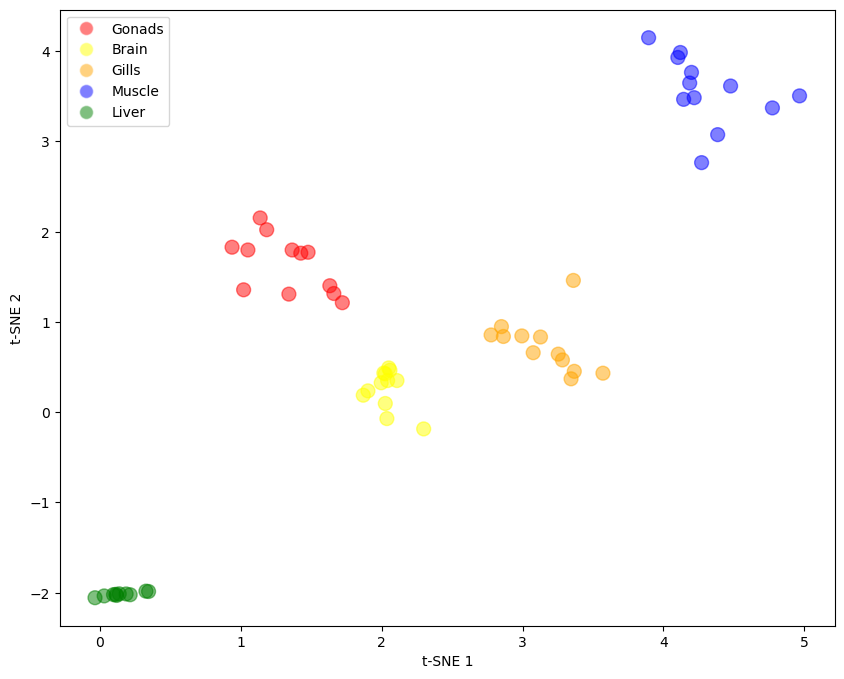

In [144]:
# Define 5 colors for the tissue categories
tissue_colors = {
    'Gonads': 'red',
    'Brain': 'yellow',
    'Gills': 'orange',
    'Muscle': 'blue',
    'Liver': 'green'
}

# Get the tissue categories
tissue_labels = dds.obs['tissue']

# Map the tissue labels to colors
colors = tissue_labels.map(tissue_colors)

# Create a scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors, s=100, alpha=0.5)

# Add axis labels
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, alpha = 0.5) for color in tissue_colors.values()]
labels = list(tissue_colors.keys())
ax.legend(handles, labels)

# Show the plot
plt.show()

In [148]:
import pandas as pd

gtf_path = f"{ana_dir}/_data/Genomic_features/Astatotilapia_calliptera.fAstCal1.2.110_chrnames.gtf"

# Read only the relevant columns
gtf = pd.read_csv(
    gtf_path,
    sep="\t",
    comment="#",
    header=None,
    names=["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"]
)

# Extract gene_id and gene_name from the attribute column
import re
gtf["gene_id"] = gtf["attribute"].str.extract('gene_id "([^"]+)"')
gtf["gene_name"] = gtf["attribute"].str.extract('gene_name "([^"]+)"')

gtf_ensembl = gtf[["gene_id", "gene_name"]].dropna().drop_duplicates()
gene_name_dict = dict(zip(gtf_ensembl["gene_id"], gtf_ensembl["gene_name"]))


## per tissue

In [277]:
tissue = "Gills" #Gonads, Brain, Liver, Muscle, Gills
sub_metadata = rna_metadata[rna_metadata['tissue']==tissue]


In [278]:
df_list = []
samples = list(sub_metadata.index)


CM_count_fp = (f'{CM_gonads_count_fp}' if tissue == 'Gonads'
            else f'{CM_brain_count_fp}' if tissue == 'Brain'
            else f'{CM_gills_count_fp}' if tissue == 'Gills'
            else f'{CM_muscle_count_fp}' if tissue == 'Muscle'
            else f'{CM_liver_count_fp}' if tissue == 'Liver'
            else None)


for i in samples:
        fn_CM = f"{CM_count_fp}/{i}_count.tsv"

        # Check if the file exists
        if os.path.exists(fn_CM):
            count_single = pd.read_csv(fn_CM, sep="\t", names=("Geneid", i)).set_index("Geneid")
        else:
            print(f"File not found for sample {i}: {fn_CC} or {fn_CM}")
            continue  # Skip to the next iteration if neither file exists

        df_list.append(count_single)

# Concatenate the list of DataFrames into a single DataFrame
counts = pd.concat(df_list, axis = 1)

counts = counts[counts.sum(axis = 1) > 0].T


all_possible_Expression_genes = count_single.index

In [279]:
count_single.index

Index(['ENSACLG00000000095', 'ENSACLG00000000097', 'ENSACLG00000000109',
       'ENSACLG00000000156', 'ENSACLG00000000174', 'ENSACLG00000000188',
       'ENSACLG00000000204', 'ENSACLG00000000208', 'ENSACLG00000000214',
       'ENSACLG00000000233',
       ...
       'ENSACLG00000006194', 'ENSACLG00000006202', 'ENSACLG00000006528',
       'ENSACLG00000006534', 'ENSACLG00000006585', 'ENSACLG00000006729',
       'ENSACLG00000006779', 'ENSACLG00000006787', 'ENSACLG00000006884',
       'ENSACLG00000007044'],
      dtype='object', name='Geneid', length=28001)

In [280]:
#make take some time to run
dds = DeseqDataSet(counts=counts,
    metadata=sub_metadata,
    design_factors="populations",)

dds.deseq2()

dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])

/data/antwerpen/grp/asvardal/miniconda3/envs/hscon6/lib/python3.10/site-packages/pydeseq2/dds.py:264: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.41 seconds.

Fitting dispersion trend curve...
... done in 0.53 seconds.

Fitting MAP dispersions...
... done in 2.21 seconds.

Fitting LFCs...
... done in 2.18 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



In [281]:
expr_matrix = dds.layers['normed_counts']


In [282]:
stat_res = DeseqStats(dds, contrast = ('populations','Lake-Malombe','Msaka')) # unclear why _ changes to -

In [283]:
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: populations Lake-Malombe vs Msaka
                      baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Geneid                                                                         
ENSACLG00000000095   23.925051        2.817484  0.888345  3.171609  0.001516   
ENSACLG00000000097  309.576726       -0.258170  0.181992 -1.418576  0.156023   
ENSACLG00000000109  238.474100       -0.710686  0.253969 -2.798320  0.005137   
ENSACLG00000000156   70.008257       -0.182411  0.218069 -0.836479  0.402885   
ENSACLG00000000174   34.960359        1.858022  0.779080  2.384893  0.017084   
...                        ...             ...       ...       ...       ...   
ENSACLG00000027183  137.184296        0.409679  0.295542  1.386196  0.165687   
ENSACLG00000027207   81.305898        0.540505  0.189277  2.855637  0.004295   
ENSACLG00000027224  943.871892        0.139788  0.299236  0.467151  0.640392   
ENSACLG00000027227  130.490830        0.229354  

... done in 1.63 seconds.



In [284]:
gene_name_dict = dict(zip(gtf_ensembl['gene_id'], gtf_ensembl['gene_name']))

In [285]:
res = stat_res.results_df

# Initialize the symbol_list
symbol_list = []

# Iterate through res.index
for i in res.index:
    if not i.startswith('ENSA'):
        symbol_list.append(i)
    elif i in gene_name_dict and gene_name_dict[i] != '':
        symbol_list.append(gene_name_dict[i])
    else:
        symbol_list.append(i)

res['Symbol'] = symbol_list
res = res[res.baseMean >= 10]

In [286]:
# Initialize the symbol_list
all_possible_express_genes_symbol = []

for i in all_possible_Expression_genes:
    if not i.startswith('ENSA'):
        all_possible_express_genes_symbol.append(i)
    elif i in gene_name_dict and gene_name_dict[i] != '':
        all_possible_express_genes_symbol.append(gene_name_dict[i])
    else:
        all_possible_express_genes_symbol.append(i)


In [287]:
len(all_possible_express_genes_symbol)

28001

In [288]:
dds_res = dds[:, res.index]

sigs = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > 0.5)] #adjust significance t

dds_sigs = dds[:, sigs.index]


In [289]:
# save significant genes here

sig_fn = f'{out_dir}/{tissue}/significant_DE_2.csv'
sigs.to_csv(sig_fn, index=True)

In [290]:
# save expr_matrix here
expr_matrix_df = pd.DataFrame(
    expr_matrix,
    columns=dds.var_names,     # genes
    index=dds.obs_names    # samples
)
expr_matrix_fn = f'{out_dir}/{tissue}/expr_matrix_DE.csv'
expr_matrix_df.to_csv(expr_matrix_fn, index=True)

In [291]:
res['nlog10'] = -np.log10(res['padj']) #make nlog10 column
res['sorter'] = res['nlog10']*res['log2FoldChange'] #make a column to pick top genes
res2 = res.dropna()
label_df = pd.concat((res2.sort_values('sorter')[-5:],
        res2.sort_values('sorter')[0:5]))
top_DE = list(label_df['Symbol'])

/tmp/ipykernel_3221858/4096363784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['nlog10'] = -np.log10(res['padj']) #make nlog10 column
/tmp/ipykernel_3221858/4096363784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['sorter'] = res['nlog10']*res['log2FoldChange'] #make a column to pick top genes


In [292]:
if tissue == 'Liver':
    res_Liver = res2
if tissue == 'Muscle':
    res_Muscle = res2
if tissue == 'Brain':
    res_Brain = res2
if tissue == 'Gonads':
    res_Gonads = res2
if tissue == 'Gills':
    res_Gills = res2


### Supplementary_S4 all DE results

In [350]:
res_dict = {
    "Muscle": res_Muscle,
    "Gills": res_Gills,
    "Gonads": res_Gonads,
    "Brain": res_Brain,
    "Liver": res_Liver
}

In [351]:
all_res = pd.concat(
    {
        tissue: df[["log2FoldChange", "nlog10"]]
        for tissue, df in res_dict.items()
    },
    axis=1
)

In [353]:
# Initialize the symbol_list
symbol_list = []

# Iterate through res.index
for i in all_res.index:
    if not i.startswith('ENSA'):
        symbol_list.append(i)
    elif i in gene_name_dict and gene_name_dict[i] != '':
        symbol_list.append(gene_name_dict[i])
    else:
        symbol_list.append(i)

all_res['Symbol'] = symbol_list

In [354]:
all_res["Geneid"] = all_res.index
all_res = all_res.set_index("Symbol")

In [356]:
threshold = 1.3  # ≈ padj<0.05
all_res["n_tissues_DE"] = (all_res.filter(like="nlog10") > threshold).sum(axis=1)


In [357]:
all_res

Muscle                     Gills            \
                   log2FoldChange     nlog10 log2FoldChange    nlog10   
Symbol                                                                  
ENSACLG00000000095      -0.118371   0.020075       2.817484  1.935143   
irak4                   -0.912065   1.828931      -0.258170  0.493560   
ghrb                    -3.968822  12.653080      -0.710686  1.542406   
ADAMTS20                 1.614256   7.386289      -0.182411  0.230840   
c7b                     -1.004051   0.647086       1.858022  1.164458   
...                           ...        ...            ...       ...   
gdf2                          NaN        NaN            NaN       NaN   
ENSACLG00000021140            NaN        NaN            NaN       NaN   
ENSACLG00000021786            NaN        NaN            NaN       NaN   
acsl5                         NaN        NaN            NaN       NaN   
ENSACLG00000026898            NaN        NaN            NaN       NaN   

                           Gonads                    Brain            \
                   log2FoldChange    nlog10 log2FoldChange    nlog10   
Symbol                                                                 
ENSACLG00000000095      -0.070697  0.022272            NaN       NaN   
irak4                    0.139081  0.030682      -0.786219  1.532333   
ghrb                    -0.405734  0.313819       0.053001  0.030899   
ADAMTS20                 0.012883  0.001327       0.091005  0.100972   
c7b                      0.235565  0.021903       0.476849  0.564269   
...                           ...       ...            ...       ...   
gdf2                          NaN       NaN            NaN       NaN   
ENSACLG00000021140            NaN       NaN            NaN       NaN   
ENSACLG00000021786            NaN       NaN            NaN       NaN   
acsl5                         NaN       NaN            NaN       NaN   
ENSACLG00000026898            NaN       NaN            NaN       NaN   

                            Liver                        Geneid n_tissues_DE  
                   log2FoldChange    nlog10                                   
Symbol                                                                        
ENSACLG00000000095      -0.715062  0.114534  ENSACLG00000000095            1  
irak4                   -0.528511  1.155767  ENSACLG00000000097            2  
ghrb                    -1.440495  4.287628  ENSACLG00000000109            3  
ADAMTS20                -0.103495  0.038466  ENSACLG00000000156            1  
c7b                           NaN       NaN  ENSACLG00000000174            0  
...                           ...       ...                 ...          ...  
gdf2                    -0.494864  0.376991  ENSACLG00000018190            0  
ENSACLG00000021140       1.268623  0.755738  ENSACLG00000021140            0  
ENSACLG00000021786       3.231180  1.622391  ENSACLG00000021786            1  
acsl5                    1.245043  0.090710  ENSACLG00000025260            0  
ENSACLG00000026898       0.454224  0.087148  ENSACLG00000026898            0  

[21347 rows x 12 columns]

In [344]:
all_res.to_csv(f"{out_dir}/all_tissues_DE_summary_S4.csv")


### plots per tissue

In [334]:
tissue

'Gills'

### Heatmap significant

In [348]:
grapher = pd.DataFrame(dds_sigs.layers['log1p'].T,
                       index=dds_sigs.var_names, columns=dds_sigs.obs_names)

/data/antwerpen/grp/asvardal/miniconda3/envs/hscon6/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/data/antwerpen/grp/asvardal/miniconda3/envs/hscon6/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


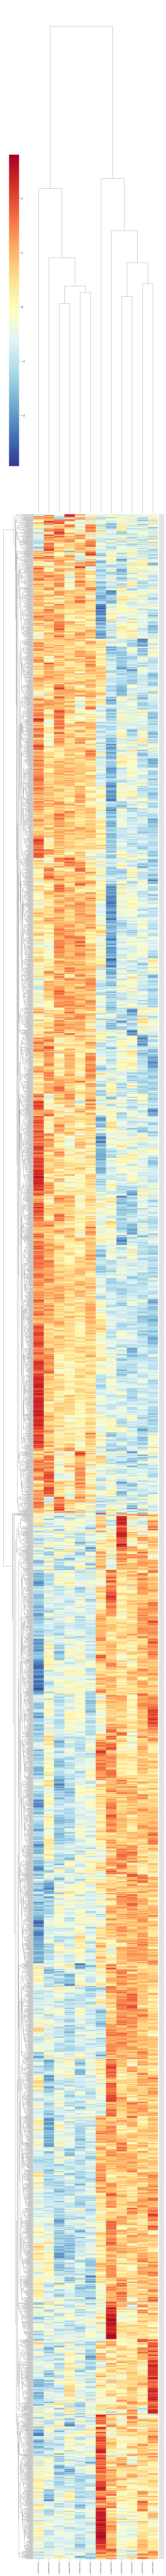

In [349]:
if len(grapher) > 1:
    clustermap = sns.clustermap(
        grapher, z_score=0, cmap='RdYlBu_r', 
        cbar_pos=(0.05, 0.82, 0.05, 0.12),
        figsize=(10,(len(grapher)/30))  # Increase figure size based on number of genes in tissue
    )
    clustermap.ax_heatmap.set_xlabel('')
    clustermap.ax_heatmap.set_ylabel('')
    reordered_index = clustermap.dendrogram_row.reordered_ind
    clustermap.ax_heatmap.set_yticks(range(len(reordered_index)))  # Set tick positions
    clustermap.ax_heatmap.set_yticklabels(
    [grapher.index[i] for i in reordered_index], fontsize=10
    )    
    plt.setp(clustermap.ax_heatmap.get_yticklabels(), fontsize=1.5, rotation=0)  # For y-axis
    plt.setp(clustermap.ax_heatmap.get_xticklabels(), fontsize=5, rotation=90)  # For x-axis
    clustermap.ax_heatmap.tick_params(axis='y', which='both', length=0)  # Remove x-axis tick marks
    clustermap.ax_heatmap.collections[0].colorbar.ax.tick_params(labelsize=10)  # Adjust colorbar tick size
    clustermap.savefig(
        f'{out_dir}/{tissue}/heatmap_significant_{tissue}_2.pdf',
        format='pdf'
    )


In [350]:
tissue

'Gills'

because plotting of colours is done based on the order in the list that values appears you have to change the order consistantly for different tissues. 

probably a solotion with colour dict, but I can't figure it out, for now just change the colour order

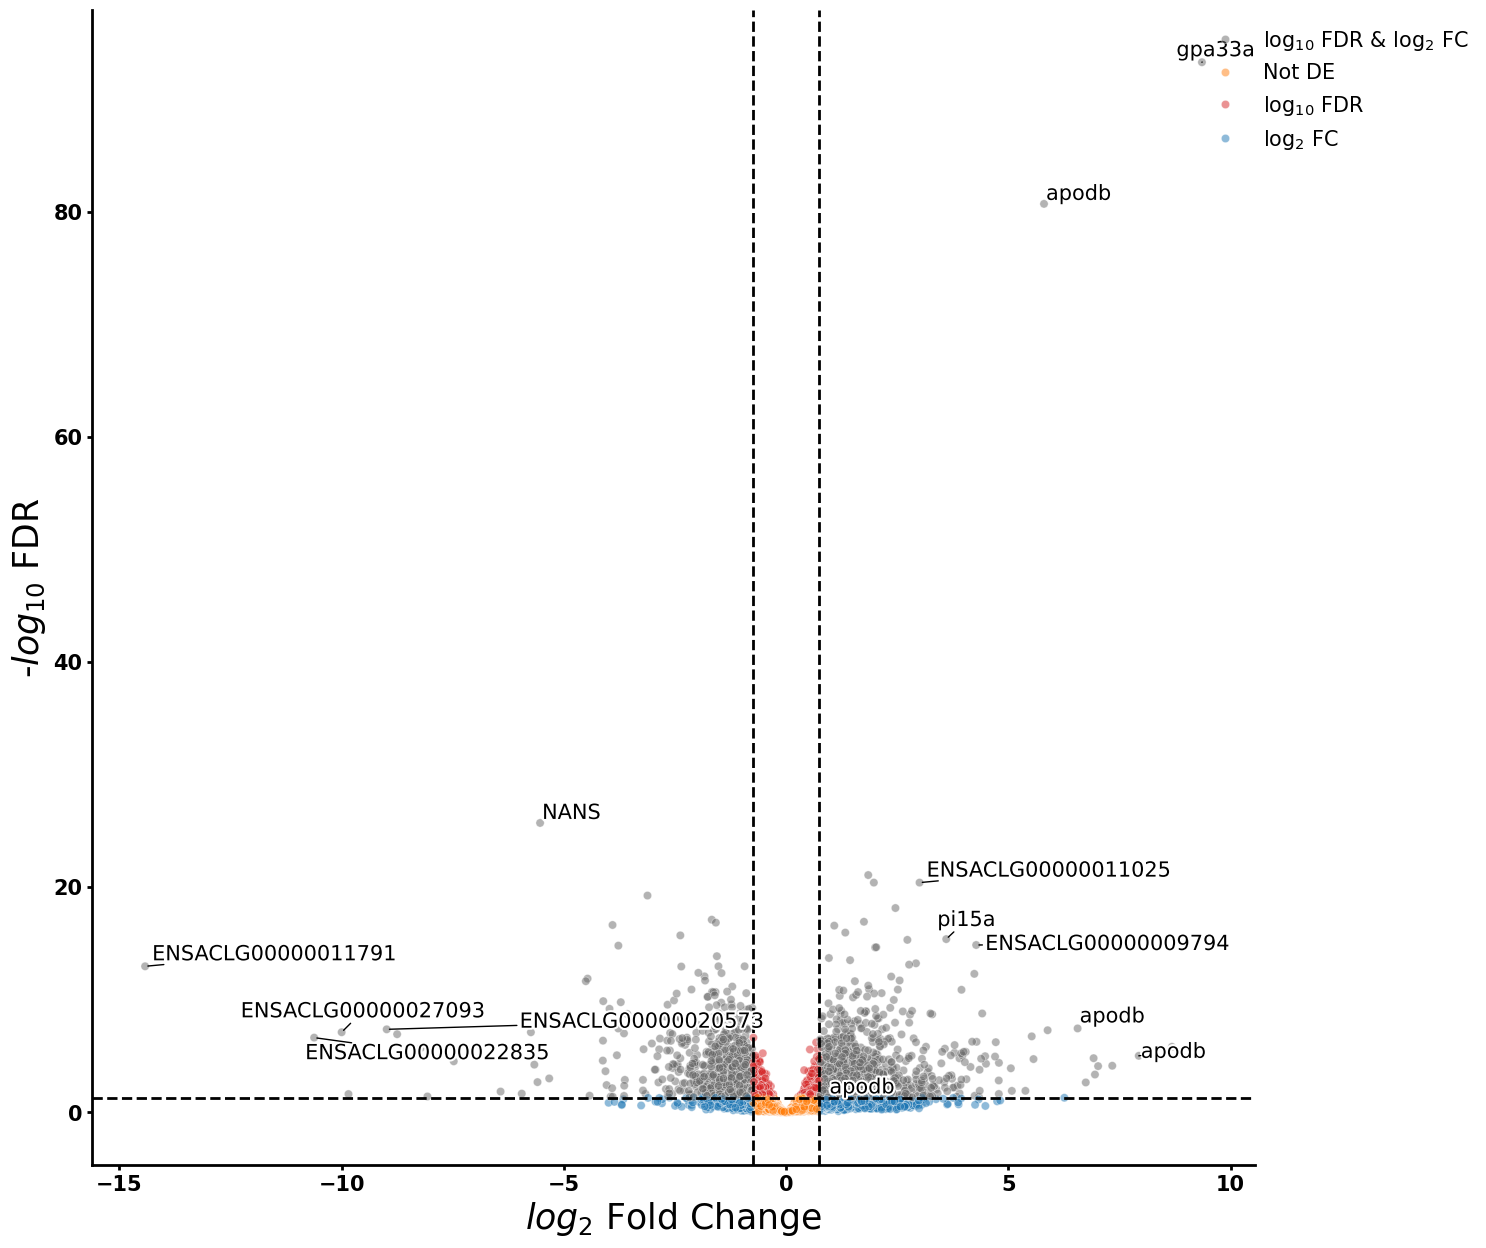

In [351]:
# Define a color dictionary for the data points
color_dict = {
#     'Not DE': 'dimgrey',  # Customize this color
}

fn = f'{out_dir}/{tissue}/volcano_labeled_{tissue}_2'

volcano2(
    res, 
    to_label=top_DE, 
    symbol='Symbol', 
    colors=['dimgrey', 'tab:orange', 'tab:red','tab:blue'],
    color_dict=color_dict, 
    save=fn, 
    figsize=(15, 15)
)
